# Chapter 7: Ensemble Learning

In [2]:
from scipy.misc import  comb
import math

In [8]:
def ensemble_error(n_classifier, error):
    k_start = math.ceil(n_classifier/ 2.0)
    probs = [comb(n_classifier, k)*
             error**k*
             (1-error)**(n_classifier-k) 
             for k in range(k_start,n_classifier +1)]
    return sum(probs)

In [9]:
ensemble_error(n_classifier=11, error=0.25)

0.034327507019042969

In [11]:
import numpy as np

In [12]:
error_range = np.arange(0.0, 1.01, 0.01)
ens_errors = [ensemble_error(n_classifier=11, error=error)
             for error in error_range]

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

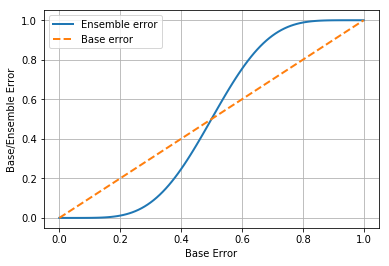

In [14]:
plt.plot(error_range, ens_errors,
        label='Ensemble error',
        linewidth=2)
plt.plot(error_range, error_range, 
        linestyle='--', label='Base error',
        linewidth=2)
plt.xlabel('Base Error')
plt.ylabel('Base/Ensemble Error')
plt.legend(loc='upper left')
plt.grid()
plt.show()

## Implementing a simple majority vote classifier

In [15]:
import numpy as np

In [18]:
np.argmax(np.bincount([0,0,1], weights=[0.2,0.2, 0.6]))

1

In [20]:
ex = np.array([[0.9, 0.1], [0.8, 0.2], [0.4, 0.6]])
p = np.average(ex, axis=0, weights=[0.2, 0.2, 0.6])
p

array([ 0.58,  0.42])

In [21]:
np.argmax(p)

0

In [22]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import six
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import operator

In [25]:
class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):
    '''A majority vote ensemble classifier
    
    Parameters:
        Classifiers: array-like, shape=[n_classifiers]
            different sklearn classifiers
        vote: str, {"claslabel", "probability"}
            default: "classlabel"
        weights: array-like, shape=[n_classifiers]
            Optional, default: None
            importance of classifiers        
    '''
    
    def __init__(self, classifiers, 
               vote='classlabel', weights=None):
        self.classifiers = classifiers
        self.named_classifiers = {key:value for 
                                  key, value in 
                                  _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights
        
    def fit(self, X, y):
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self
        
    def predict(self, X):
        if self.vote=='probility':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:
            predictions = np.asarray([clf.predict(X) for
                                     clf in
                                     self.classifiers_]).T
            maj_vote = np.apply_along_axis(
                lambda x:
                np.argmax(np.bincount(x,weights=self.weights)),
                axis=1,
                arr=predictions)
            
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote
    
    def predict_proba(self, X):
        probas = np.asarray([clf.predict_proba(X) for
                            clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba
    
    def get_params(self, deep=True):
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in six.iteritems(self.named_classifiers):
                for key, value in six.iteritems(step.get_params(deep=True)):
                    out['{}__{}'.format(name,key)] = value
            return out
        

In [26]:
from sklearn import datasets
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [27]:
iris = datasets.load_iris()
X, y = iris.data[50:,[1,2]], iris.target[50:]

In [28]:
le = LabelEncoder()
y = le.fit_transform(y)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)

In [31]:
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

In [32]:
clf1 = LogisticRegression(penalty='l2', C=0.001, random_state=0)
clf2 = DecisionTreeClassifier(max_depth=1, criterion='entropy', random_state=0)
clf3 = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')
pipe1 = Pipeline([
    ('sc', StandardScaler()),
    ('clf', clf1)])
pipe3 = Pipeline([
    ('sc', StandardScaler()),
    ('clf', clf3)])
clf_labels = ['Logistic Regression', 'Decision Tree', 'KNN']

#### 10-fold cross validation:

In [33]:
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train,
                            y=y_train, cv=10, scoring='roc_auc')
    print('ROC_AUC:{:.2f} +/- {:.2f} {}'.format(scores.mean(), scores.std(), label))

ROC_AUC:0.92 +/- 0.20 Logistic Regression
ROC_AUC:0.92 +/- 0.15 Decision Tree
ROC_AUC:0.93 +/- 0.10 KNN


In [34]:
mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])

In [35]:
clf_labels += ['Majority Voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]

In [36]:
for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train,
                            y=y_train, cv=10, scoring='roc_auc')
    print('ROC_AUC:{:.2f} +/- {:.2f} {}'.format(scores.mean(), scores.std(), label))

ROC_AUC:0.92 +/- 0.20 Logistic Regression
ROC_AUC:0.92 +/- 0.15 Decision Tree
ROC_AUC:0.93 +/- 0.10 KNN
ROC_AUC:0.97 +/- 0.10 Majority Voting


## Evaluating and Tuning the Ensemble Classifier

In [37]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [38]:
colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']

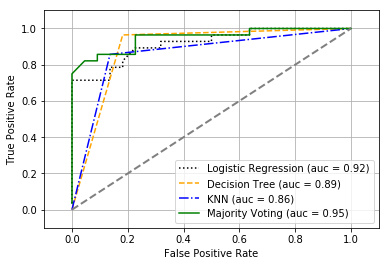

In [42]:
for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test,
                                    y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr, color=clr, linestyle=ls,
            label='{} (auc = {:.2f})'.format(label, roc_auc))
    
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], linestyle='--', color='gray', linewidth=2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()
    

In [43]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)

In [44]:
from itertools import product

In [45]:
x_min = X_train_std[:,0].min()-1
x_max = X_train_std[:,0].max()+1
y_min = X_train_std[:,1].min()-1
y_max = X_train_std[:,1].max()+1

In [48]:
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

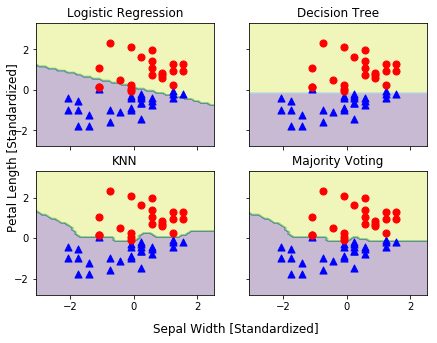

In [49]:
f, axarr = plt.subplots(nrows=2, ncols=2, sharex='col', sharey='row', figsize=(7,5))
for idx, clf, tt in zip(product([0,1], [0,1]), all_clf, clf_labels):
    clf.fit(X_train_std, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==0, 0],
                                 X_train_std[y_train==0, 1],
                                 c='blue', marker='^', s=50)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==1, 0],
                                 X_train_std[y_train==1, 1],
                                 c='red', marker='o', s=50)
    axarr[idx[0], idx[1]].set_title(tt)
    
plt.text(-3.5, -4.5, s='Sepal Width [Standardized]', ha='center',
        va='center', fontsize=12)
plt.text(-10.5, 4.5, s='Petal Length [Standardized]', ha='center',
        va='center', fontsize=12, rotation=90)
plt.show()

In [51]:
mv_clf.get_params()

{'decisiontreeclassifier': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=1,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False, random_state=0,
             splitter='best'),
 'decisiontreeclassifier__class_weight': None,
 'decisiontreeclassifier__criterion': 'entropy',
 'decisiontreeclassifier__max_depth': 1,
 'decisiontreeclassifier__max_features': None,
 'decisiontreeclassifier__max_leaf_nodes': None,
 'decisiontreeclassifier__min_impurity_decrease': 0.0,
 'decisiontreeclassifier__min_impurity_split': None,
 'decisiontreeclassifier__min_samples_leaf': 1,
 'decisiontreeclassifier__min_samples_split': 2,
 'decisiontreeclassifier__min_weight_fraction_leaf': 0.0,
 'decisiontreeclassifier__presort': False,
 'decisiontreeclassifier__random_state': 0,
 'decisiontreeclassifier__splitter': 

In [52]:
from sklearn.grid_search import GridSearchCV

In [56]:
params = {'decisiontreeclassifier__max_depth':[1,2],
         'pipeline-1__clf__C':[0.001, 0.1, 100.0]}

In [57]:
grid = GridSearchCV(estimator=mv_clf,
                   param_grid=params,
                   cv=10,
                   scoring='roc_auc')

In [58]:
grid.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=MajorityVoteClassifier(classifiers=[Pipeline(memory=None,
     steps=[('sc', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', ra...ski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform'))])],
            vote='classlabel', weights=None),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'decisiontreeclassifier__max_depth': [1, 2], 'pipeline-1__clf__C': [0.001, 0.1, 100.0]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [60]:
for params, mean_score, scores in grid.grid_scores_:
    print('{:.3f} +/- {:.2f} {}'.format(mean_score, scores.std()/2, params))

0.967 +/- 0.05 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
0.967 +/- 0.05 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1}
1.000 +/- 0.00 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
0.967 +/- 0.05 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001}
0.967 +/- 0.05 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1}
1.000 +/- 0.00 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100.0}


## Bagging - building and esemble from bootstrap samples

In [61]:
import pandas as pd

In [62]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/'+
                      'ml/machine-learning-databases/wine/wine.data',
                     header=None)

In [67]:
df_wine.columns = ['Class label', 'Alcohol',
                  'Malic acid', 'Ash', 'Alcalinity of ash',
                  'Magnesium', 'Total phenols',
                  'Flavanoids', 'Nonflavanoid phenols',
                  'Proanthocyanins', 'Color intensity',
                  'Hue', 'OD280/OD315 of diluted wines',
                  'Proline']

In [68]:
df_wine = df_wine[df_wine['Class label'] != 1]

In [69]:
df_wine.head()

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
59,2,12.37,0.94,1.36,10.6,88,1.98,0.57,0.28,0.42,1.95,1.05,1.82,520
60,2,12.33,1.10,2.28,16.0,101,2.05,1.09,0.63,0.41,3.27,1.25,1.67,680
61,2,12.64,1.36,2.02,16.8,100,2.02,1.41,0.53,0.62,5.75,0.98,1.59,450
62,2,13.67,1.25,1.92,18.0,94,2.10,1.79,0.32,0.73,3.80,1.23,2.46,630
63,2,12.37,1.13,2.16,19.0,87,3.50,3.10,0.19,1.87,4.45,1.22,2.87,420
